<a href="https://colab.research.google.com/github/hduongck/AI-ML-Learning/blob/master/Excercise/Transfer_Learning_in_NLP_for_Tweet_Stance_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer Learning in NLP for Tweet Stance Classification

A comparison of two transfer learning methods in Natural Language Processing: “ULMFiT” and “OpenAI GPT” for a multi-class classification task involving Twitter data

![alt text](https://cdn-images-1.medium.com/max/1200/1*-hnEkyzxq_ZgOs9jBuGj0g.png)

2018 has been a hugely exciting year in the field of Natural Language Processing (NLP), in particular, for transfer learning — a technique where instead of training a model from scratch, we use models pre-trained on a large dataset and then fine-tune them for specific natural language tasks. Sebastian Ruder provides an excellent account of the past and current state of transfer learning in his post “[NLP’s ImageNet moment has arrived](http://ruder.io/nlp-imagenet/)”, explaining why this is such a hot field in NLP right now — **his post is a must read**.

In recent times, methods such as [ULMFiT](http://nlp.fast.ai/classification/2018/05/15/introducting-ulmfit.html), [OpenAI GPT](https://blog.openai.com/language-unsupervised/), [ELMo](https://allennlp.org/elmo) and [Google AI’s BERT](https://arxiv.org/pdf/1810.04805.pdf) **have revolutionized the field of transfer learning in NLP by using language modelling during pre-training**, which has significantly improved on the state-of-the-art for a variety of tasks in natural language understanding. It can be argued that the use of language modelling (which is not without its limitations) is one of the main reasons computers have shown great improvements in their semantic understanding of language.

One interesting aspect of the transfer learning methods mentioned above is that they use language models pre-trained on well-formed, massive curated datasets that include full sentences with a clear syntax (such as [Wikipedia articles](https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/) and [the 1 billion word benchmark](https://ai.google/research/pubs/pub41880)). The natural question that arises is — how well can such pre-trained language models generalize to natural language tasks from a different distribution, such as Tweets?

##Goal of this post

In this post we will discuss and compare two modern transfer learning approaches — ULMFiT and OpenAI’s GPT (“Generative Pre-Training”), and show how they can be fine-tuned with relative ease to perform classification tasks from a different distribution — in this case, classifying the stance of Tweets towards a target topic.

We will aim to develop a modelling approach that can help answer the following questions:

- Does our fine-tuned language model (and classifier) generalize to the unstructured and messy language syntax of Tweets?
- Can we achieve reasonable accuracy (comparable to a benchmark result from 2016) with minimal task-specific customization for each model and with limited computing resources?
- How do the classification results vary based on the model architecture used?

All the code and data for the results shown below are available in [this GitHub repo](https://github.com/prrao87/tweet-stance-prediction).

**A full description of ULMFiT and OpenAI’s GPT is too long a topic for this post, but [this article](https://medium.com/explorations-in-language-and-learning/transfer-learning-in-nlp-2d09c3dfaeb6) does an excellent job of highlighting the technical details of both model architectures and why they matter, so please do read it!**

##Background

Before going into the details of transfer learning for Tweet stance classification, let’s clarify some terminology to understand why transfer learning has so drastically improved state-of-the-art for a variety of natural language tasks in recent times.



###Moving on from word embeddings

Historically, pre-trained word embedding techniques such as [word2vec](http://papers.nips.cc/paper/5021-distributed-representations-of-words-andphrases) and [GloVe](https://nlp.stanford.edu/pubs/glove.pdf), were heavily used in NLP to initialize the first layer of a neural network before training for a new task. These are shallow representations (a single layer of weights, known as embeddings). Any prior knowledge from the word embeddings are only present in the first layer of the network — the entire network would still need to be trained from scratch for a new target task.

To derive meaning from sequences of words (such as those seen in natural language), models that utilize word embeddings would still need tremendous amounts of data to disambiguate large sets of words and “learn” from a completely new and unseen vocabulary. **As shown in a benchmark result discussed later in this post, the amount of data required for transferring knowledge through word embeddings can be huge, which can result in very large computational costs**. Throughout 2018, the advent of [powerful pre-trained language models](https://www.sysml.cc/doc/50.pdf) have shown that is possible to gain a much deeper understanding of language semantics and structure for new tasks, especially for long sequences, using the knowledge gained from pre-training on large text corpora.



###Language Modelling

A language model attempts to learn the structure of natural language through hierarchical representations, and thus contains both low-level features (word representations) and high-level features (semantic meaning). A key feature of language modelling is that it is generative, meaning that it aims to predict the next word given a previous sequence of words. It is able to do this because **language models are typically trained on very large datasets in an unsupervised manner, and hence the model can “learn” the syntactic features of language in a much deeper way than word embeddings**.

[In his post](http://ruder.io/nlp-imagenet/), Sebastian Ruder does a very elegant job of highlighting why language modelling is so powerful for a broad range of NLP tasks. Unlabelled language data is relatively easy to obtain (it is freely available in the form of large text corpora), so by feeding a language model a sufficiently large dataset, it is now possible to perform unsupervised pre-training on billions of words while incorporating a deeper knowledge of language syntax.

**Semi-supervised learning**

Transfer learning in NLP is now typically done as a multi-step process— where an entire network is first pre-trained in an unsupervised manner with a language modelling objective. Following this, the model is then fine-tuned on a new task using a supervised approach (with some labelled data), which can then be used for tasks such as text classification. This combination of unsupervised pre-training (using language modelling) followed by supervised fine-tuning is termed as semi-supervised learning, and is the approach used to solve our Tweet stance classification problem in this post.

##Dataset Used

The Tweet dataset used in this post comes from this SemEval 2016 shared task, which contains Tweets that pertain to the following five topics :

- Atheism
- Climate change is a concern
- Feminist movement
- Hillary Clinton
- Legalization of abortion

The labelled data provided consists of a target topic, a Tweet that pertains to it, and stance of the Tweet towards the target. The data is already split into a training set (containing 2,914 Tweets) and a test set (containing 1,249 Tweets). The stance can be one of three labels: “FAVOUR”, “AGAINST” and “NEITHER”, hence this is a multi-class dataset.

![alt text](https://cdn-images-1.medium.com/max/800/1*A4sRK2Vq15ROr7aYjceOWA.png)



###The challenge of detecting stance

Stance detection is a subcategory of opinion mining, where the task is to automatically determine whether the author of a piece of text is in favour or against a given target. Consider the following two Tweets:

```
We don’t inherit the earth from our parents we borrow it from our children
Last time I checked, Al Gore is a politician, not a scientist.
```
To a human observer, it is reasonably clear that both Tweets are relevant to the topic of climate change, and that each expresses a particular stance towards the topic of climate change. However, to a machine, detecting this stance is a difficult problem on multiple fronts. The informal and unstructured syntax of Tweets combined with the fact that machines lack proper contextual awareness and historical knowledge that humans have (for example, knowing who Al Gore is), makes this a challenging problem for machine learning algorithms. In addition, gathering large amounts of labelled data for Tweet stance in order to train a machine learning algorithm is expensive and tedious. It is becoming more and more necessary to develop deep learning methods that can work with limited amounts of training data and still yield useful insights.

**Stance and sentiment are not the same!**

Stance detection is related to, but not the same as sentiment analysis. In sentiment analysis, we are interested in whether a piece of text is positive, negative, or neutral based on just the content of the language used. Typically, for sentiment analysis, the choice of positive or negative language correlates with the overall sentiment of the text.

However, the stance of a piece of text is defined with respect to a target topic, and can be independent of whether positive or negative language was used. The target (topic towards which opinion is expressed) may or may not be mentioned directly in the actual text, and any entities mentioned in the text may or may not be the actual target of opinion. Below is an example from the [task creators’ paper.](https://arxiv.org/pdf/1605.01655.pdf)



```
Topic: legalization of abortion
Tweet: The pregnant are more than walking incubators. They have rights too!
Stance: Favour
```

In the above example, since the topic is phrased as “legalization of abortion”, the Tweet can be interpreted as being in favour of the topic. Had it been phrased as “Pro-life movement”, its stance would have been against the topic. It is clear from this example that the language used in the Tweet is only loosely positive in its sentiment; however this sentiment has no bearing on whether it is in favour of, or against the topic.

**Class Imbalance**

The below table shows a breakdown of how many Tweets pertain to each topic in the dataset. The 2,914 Tweets are distributed unequally per topic, and there is significant variation in the number of Tweets belonging to each class for each topic. To explore the distribution and inspect the Tweets in more detail, take a look at the fully interactive visualization provided by the task creators.

![alt text](https://cdn-images-1.medium.com/max/800/1*2-sDmSXLreNqfHQK14EJwA.png)

![](https://cdn-images-1.medium.com/max/800/1*Qp_wDFPHC8AkmxPJ5HgwMA.png)

Looking at this distribution, the stance classification task appears quite challenging — not only is the dataset small (a couple of thousand training samples in total, ranging from a minimum of 395 to a maximum 689 Tweets per topic) — but there is also a significant class imbalance in the samples. For example, the topic “climate change is a concern” has a larger percentage of training samples classified as “favour”, and a very small percentage (less than 4%) classified as “against”. On the other hand, the topic “atheism” has a much larger fraction of its samples classified as “against”.

Any modelling approach for stance classification must be able to capture this class imbalance, both between and within the target classes.

###Evaluation Metric Used

To evaluate classification performance, the creators of the task use a [macro-averaged F-score](http://www.aclweb.org/anthology/S16-1003), which is the harmonic mean of precision and recall for the two main classes “FAVOUR” and “AGAINST”. An example of how precision and recall are used in sentiment classification is given [here](https://streamhacker.com/2010/05/17/text-classification-sentiment-analysis-precision-recall/). In general, precision is at odds with recall, and hence the F-score provides a good way to gain insights into a classifier’s performance. Although we do not include the third class “NEITHER” in the evaluation, it is implicitly accounted for, since the system has to correctly predict all three classes to avoid being penalized heavily in either of the first two.

To evaluate the F-score, a [perl script](http://alt.qcri.org/semeval2016/task6/index.php?id=data-and-tools) (whose usage will be described in later sections) was provided by the task creators— all we need to do is shape our stance classifier’s prediction output in a way that can be read by the evaluation script. The macro-averaged F-score obtained can then be compared with other models’ results.



###Benchmark Result for Comparison: MITRE

The winning entry for this task in 2016 was from team MITRE, who describe their classification approach [in this paper](https://arxiv.org/pdf/1606.03784.pdf). To detect stance, MITRE used a Recurrent Neural Network (RNN) model organized into 4 layers as shown in the below image. The first layer contained one-hot-encoded tokens (i.e. words from the text) that were projected through a 256-embedding layer called the “projection layer”. The sequence of outputs were then fed into a “recurrent layer” (containing 128 LSTM units), whose output was then connected to a 128-dimensional layer of Rectified Linear Units (ReLUs) with 90% dropout. The final output layer was a 3-dimensional softmax layer representing each output class: FAVOUR, AGAINST and NONE.

![alt text](https://cdn-images-1.medium.com/max/800/1*QxegdHYn8Ja-WmAfODym7w.png)

MITRE also applied transfer learning (via the use of word embeddings) to reuse prior knowledge of Tweet syntax from a pre-trained model. This was accomplished through a multi-step pre-training process as described below:

1. **Pre-training the projection layer:** The weights for the projection layer were initialized from 256-dimensional word embeddings learned using the [word2vec skip-gram method](https://arxiv.org/pdf/1301.3781.pdf). To do this, [MITRE extracted 218,179,858 English Tweets](https://arxiv.org/pdf/1606.03784.pdf) from Twitter’s public streaming API and then performed weakly supervised learning on this unlabelled dataset (after cleaning the Tweets and lower-casing them). To learn the meaning of compound phrases, they then applied [word2phrase](https://arxiv.org/pdf/1606.03784.pdf) to identify phrases comprised of up to four words. Out of the 218 million Tweets sampled, 537,366 vocabulary items were used (that appeared at least 100 times in the corpus).

2. **Pre-training the recurrent layer**: The second layer of MITRE’s network, which consisted of 128 LSTM units, was initialized with weights pre-trained using distant supervision of a hashtag prediction auxiliary task. To begin, 197 hashtags were automatically identified that were relevant to the five topics under consideration (using a nearest-neighbour search of the word embedding space). Then, 298,973 Tweets (out of the total 218 million) were extracted that contained at least one of these 197 hashtags, and the network was trained to tune the word embeddings and the recurrent layer. Like before, the Tweets were lower-cased, stripped of all hashtags and phrase-chunked before tokenization.

**Results: MITRE**

The F-scores on unseen test data for each topic and class obtained by MITRE are shown below. Note that for the topic class “Climate change (AGAINST)”, the F-score is zero, meaning that their model did not predict any Tweets from the test set as being against climate change. However, just 3.8% of the training data from the climate change topic was of the class “AGAINST” (which amounts to just 15 training samples!), so it makes sense that the model might be lacking context for this particular class due to the sheer lack of training samples.

![](https://cdn-images-1.medium.com/max/1600/1*_lYamPnTUOBu2KkplFL8QA.png)

As [mentioned in their paper](https://arxiv.org/pdf/1606.03784.pdf), MITRE obtained a macro F-score (averaged across all topics) of 0.68. This was the best score among all 19 participants who submitted their results to the competition in 2016.

The approach used by MITRE was a rather elaborate multi-step pre-training procedure using word embeddings that required the use of very large unlabelled datasets (hundreds of millions of samples), significant cleaning of the raw data and separate pre-training steps for each layer in the network. **The multitude of hand-crafted steps was mainly because of the limitations of word2vec embeddings** (which was the dominant approach to pre-training models in NLP at the time).

# Method 1: ULMFiT

ULMFiT has been entirely implemented in v1 of the fastai library (see fastai.text on their GitHub repo). Version 1 of fastai is built on top of PyTorch v1, so having some knowledge of PyTorch objects is beneficial to get started. In this post, we cover some of the techniques that fastai has developed that make it very convenient to do transfer learning, even for someone with relatively little deep learning experience.

##Training Steps

As described in the original paper, ULMFiT consists of three stages.

1. Training the language model on a general-domain corpus that captures high-level natural language features
2. Fine-tuning the pre-trained language model on target task data
3. Fine-tuning the classifier on target task data

![alt text](https://cdn-images-1.medium.com/max/2400/1*w_qNXVr7N2OPCK5iMnHAVQ.png)

**We only perform steps 2 and 3** during Tweet stance classification. Step 1 is an unsupervised pre-training step, and is really computationally expensive — which is why the models have been [made available publicly](https://github.com/fastai/fastai/blob/master/fastai/datasets.py) by fastai so others can benefit from their work. We bank on the pre-trained language model’s ability to capture long-term dependencies in any target text (in English) that we might encounter.

All the code for this section is available in a Jupyter notebook [ulmfit.ipynb](https://github.com/prrao87/tweet-stance-prediction/blob/master/ulmfit.ipynb). For brevity, only the key elements of the approach are discussed in this post — feel free to look through the full notebook and this project’s main GitHub repo for a deep-dive into the working code for classifying Tweet stance.

- **Discriminative Fine-tuning**: Each layer of the model captures different types of information. Hence, it makes sense to fine-tune each layer’s learning rates differently, and this is done in ULMFiT based on [extensive empirical testing and implementation updates](https://github.com/cedrickchee/knowledge/blob/master/courses/fast.ai/deep-learning-part-2/2018-edition/lesson-10-transfer-learning-nlp.md). It was empirically found that first fine-tuning only the last layer (with the others frozen), and then unfreezing all the layers and applying a learning rate lowered by a factor of 2.6 for all other layers during language model fine-tuning [worked well in most cases.](https://arxiv.org/pdf/1801.06146.pdf)

- **1-cycle learning rate policy**: In the fine-tuning stage, we apply 1-cycle learning rates, which comes from this [report by Leslie Smith](https://arxiv.org/abs/1803.09820). It is a modification of the cyclical learning rate policy, which has been around for a long time, but the 1-cycle policy allows a larger initial learning rate (say max_LR = 1e-03), but decreases it by several orders of magnitude just at the last epoch. This seems to provide greater final accuracy. Note that this doesn’t mean we run it for one epoch — the ‘1’ in 1-cycle means it just cycles the learning rate down one epoch before the max epochs that we specify. In the ULMFiT implementation, this 1-cycle policy has been tweaked and is referred to as *slanted triangular learning rates*.

- **Gradual unfreezing**: During classification, rather than fine-tuning all the layers at once, the layers are “frozen” and the last layer is fine-tuned first, followed by the next layer before it, and so on. This avoids the phenomenon known as **catastrophic forgetting** (by losing all prior knowledge gained from the language model).

- **Concatenated pooling**: Pooling is a component of neural networks to aggregate the learned features and reduce the overall computational burden of a large network. In case you’re curious, a good introduction to pooling as applied in LSTMs is given [in this paper](https://arxiv.org/pdf/1706.05157.pdf). In ULMFiT, because an input text can consist of hundreds or thousands of words, information might get lost if we only consider the last hidden state in the LSTM. To avoid this information loss, the hidden state at the last time step is concatenated with both the max-pooled and mean-pooled representation of the hidden states over as many time steps as can fit in GPU memory.



This notebook shows how transfer learning, an extension of deep learning, can be used for predicting Tweet stance toward a particular topic.

- https://towardsdatascience.com/transfer-learning-in-nlp-for-tweet-stance-classification-8ab014da8dde
- https://github.com/prrao87/tweet-stance-prediction/blob/master/ulmfit.ipynb


# 1.Motivation

The traditional approach to applying deep learning methods in NLP have involved feeding a model large amounts of labeled training data, and fitting the model's parameters to this data. In practice, natural language data is highly variable and can come in a variety of forms (tweets, blog posts, reviews etc.), and hence, a model trained for a particular language task does not generalize well to new data from another distribution. In addition, many natural language applications do not come with an abundance of labeled examples, and human annotation can get very expensive as the datasets get larger.

This offers good motivation to explore the notion of transfer learning - a machine-learning technique that has the ability to transfer knowledge to novel scenarios not encountered during training. While transfer learning has been ubiquitous throughout computer vision applications since the advent of huge datasets such as ImageNet, it is only since 2017-18 that significant progress has been made for transfer learning in NLP applications. There have been a string of interesting papers in 2018 that discuss the power of language models in natural language understanding and how they can be used to provide pre-trained representations of a language's syntax, which can be far more useful when training a neural network for previously unseen tasks.

Twitter data is a very interesting use case for transfer learning, mainly because the typical language syntax seen in Tweets is quite different from that which is used to train language models. For these reasons, the 2016 SemEval Stance Detection task is chosen for studying the effectiveness of our transfer learning approach. The dataset, experiments and the evaluation criteria used are explained in below sections.

The aim of this notebook is to highlight the development of a model that can help answer the following questions:

- How does our approach generalize to Twitter-specific language syntax?
- Are we able to achieve reasonable results (comparable to the winning team of SemEval 2016 Task 6) with limited amounts of training data and limited computing resources?
- How much fine-tuning effort is required to achieve reasonable results?



#2.Approach

This section describes the 3-Layer LSTM architecture used for transfer learning, ULMFit. This is the architecture described in the well known paper by Howard and Ruder, 2018, that has been proven to generalize well to unseen distributions. The goal is to see how ULMFit can perform in this particular Tweet stance classification task.



##2.1 ULMFit Model Architecture

![alt text](https://github.com/prrao87/tweet-stance-prediction/raw/f12cf924db7c947d5b681c01f492da029c08c415/assets/ulmfit_arch.png?raw=true)

Source: Howard and Ruder, 2018

To classify out-of-domain data (such as our Twitter data), the following techniques are applied from the ULMFit paper:

**Discriminative Fine-tuning¶**

From the ULMFit paper, each layer of the model captures different types of information. Hence, it makes sense to fine-tune each layer differently, and this is done in ULMFit after extensive empirical testing and implementation updates. Rather than change each layer manually, we can use the implemented ratios, but adapt the multiplier that influences the learning rate for each layer.

ULMFit also uses discriminative fine-tuning with regard to the SGD update as follows:

$\theta_{t}^{l} = \theta_{t-1}^{l} - \eta^{l} \cdot \nabla_{\theta^l} J{\theta} $

**1-cycle learning rate policy**

In the fine-tuning stage, a 1-cycle learning rate policy is applied, which comes from this report by Leslie Smith. It is a modification of the cyclical learning rate policy, which has been around for a long time, but the 1-cycle policy allows a large initial learning rate ($LR_{max}=10^{-3}$, for example), but decreases it by several orders of magnitude just at the last epoch. This seems to provide greater final accuracy. In the ULMFit implementation, this 1-cycle policy has been tweaked and is referred to as slanted triangular learning rate.

**Gradual unfreezing**

Rather than training all the layers at once during classification, the layers are "frozen" and the last layer is fine-tuned first, followed by the next layer before it, and so on. This avoids the phenomenon known as catastrophic forgetting (by fine-tuning all layers too aggressively).

**Concatenated pooling**

Because an input text can consist of hundreds or thousands of words, information might get lost if we only consider the last hidden state.

Hence, the hidden state at the last time step, $h_T$ is concatenated with both the max-pooled and mean-pooled representation of the hidden states over as many time steps as can fit in GPU memory.

$h_C = [h_T, maxpool(H), meanpool(H)]$

Where $H$ is the vector of all hidden states.

**3-stage fine-tuning methodology**

The classification task is done in a 3-stage process:

- General-domain LM pretraining: ULMFit has a pretrained model generated using an AWD-LSTM (as per Merity et al., 2017)) to develop a language model called Wikitext-103 and was trained of 28,595 preprocessed Wikipedia articles, totalling to 103 million words.
- Target task LM fine-tuning: Since the data for the target will likely come from a different distribution, ULMFit allows us to use the pre-trained language model and fine-tune it (using the above techniques) to adapt to the idiosyncrasies of the target data.
- Target task classifier fine-tuning: Once we save the updated weights from the language model fine-tuning step, we can fine-tune the classifier with gradual unfreezing and the other techniques described above to perform task-specific class prediction.
- Note that for this SemEval Tweet stance classification task, we only perform steps 2 and 3, and utilize the pretrained language model from the fastai database.



#3. Data

The training and test data consist of Tweets pertaining to five distinct topics, shown in SemEval 2016: Task 6. We only look at Task A: "Supervised Framework" in this notebook. The train and test data (including the gold) are in the the data/ directory provided along with this repository.

The five topics for which Tweets are provided as part of the training data are given below.

-Topic
 - Atheism
 - Climate Change is a Real Concern
 - Feminist Movement
 - Hillary Clinton
 - Legalization of Abortion
 
A more detailed breakdown of the tweets for this shared task is provided in this link.

**Size of dataset**

The total number of Tweets (in the training set) available for this task is roughly 2700, which amounts to roughly 500-600 Tweets per topic. Thus, this can be considered a small dataset.

![alt text](https://github.com/prrao87/tweet-stance-prediction/raw/f12cf924db7c947d5b681c01f492da029c08c415/assets/stance_balance.png?raw=true)

Upon inspecting the training data, it is clear that there is quite a large variance in terms of the number of Tweets in favor vs. those against a topic. There is quite a large variance within classes as well as between classes in the overall data.


##3.1 Pretrained language models

ULMFit uses its own pretrained language model wikitext-103 that can be conveniently downloaded from the fastai database hosted on AWS.

##3.2 Preprocess SemEval training data

The original Tweets can contain some arbitrary non-English characters, so we take care of this before loading in the language model. Note that this only removes non-English characters, but does not do any other kind of aggressive pre-processing (like lower-casing or removing entire words or hashtags). We retain the entirety of the information in the raw data and let the language model do the heavy lifting.

This section discusses the steps used to prepare the data for transfer learning utilizing the fastai framework. In particular, the fastai.text library is designed to work very well with tabular data, hence, Pandas DataFrames are used to organize and filter the data.

In [0]:
from fastai import *
from fastai.text import *

**Define the path to train and test data for SemEval 2016 Task 6**

The full data and evaluation files for this task is available on the [source page](http://alt.qcri.org/semeval2016/task6/index.php?id=data-and-tools). However, these have been included along with this repository for future reference.

In [0]:
!wget http://alt.qcri.org/semeval2016/task6/data/uploads/semeval2016-task6-trainingdata.txt
!wget http://alt.qcri.org/semeval2016/task6/data/uploads/semeval2016-task6-testdata.zip

--2019-06-02 01:17:14--  http://alt.qcri.org/semeval2016/task6/data/uploads/semeval2016-task6-trainingdata.txt
Resolving alt.qcri.org (alt.qcri.org)... 13.93.27.76
Connecting to alt.qcri.org (alt.qcri.org)|13.93.27.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 397092 (388K) [text/plain]
Saving to: ‘semeval2016-task6-trainingdata.txt’

semeval2016-task6-t 100%[===================>] 387.79K   892KB/s    in 0.4s    

2019-06-02 01:17:15 (892 KB/s) - ‘semeval2016-task6-trainingdata.txt’ saved [397092/397092]

--2019-06-02 01:17:16--  http://alt.qcri.org/semeval2016/task6/data/uploads/semeval2016-task6-testdata.zip
Resolving alt.qcri.org (alt.qcri.org)... 13.93.27.76
Connecting to alt.qcri.org (alt.qcri.org)|13.93.27.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104831 (102K) [application/zip]
Saving to: ‘semeval2016-task6-testdata.zip’

semeval2016-task6-t 100%[===================>] 102.37K   320KB/s    in 0.3s    

2019-06-02 01:

In [0]:
!unzip semeval2016-task6-testdata.zip

Archive:  semeval2016-task6-testdata.zip
   creating: SemEval2016-Task6-testdata/
  inflating: SemEval2016-Task6-testdata/SemEval2016-Task6-subtaskA-testdata.txt  
  inflating: SemEval2016-Task6-testdata/SemEval2016-Task6-subtaskB-testdata.txt  
  inflating: SemEval2016-Task6-testdata/SemEval2016-Task6-testdata-README.txt  


In [0]:
os.makedirs('data/twitter/',exist_ok=True)

In [0]:
shutil.copy('/content/SemEval2016-Task6-testdata/SemEval2016-Task6-subtaskA-testdata.txt','/content/data/twitter/')
shutil.copy('/content/semeval2016-task6-trainingdata.txt','/content/data/twitter/')

'/content/data/twitter/semeval2016-task6-trainingdata.txt'

In [0]:
path = '/content/data/twitter/'
trainfile = 'semeval2016-task6-trainingdata.txt'
testfile = 'SemEval2016-Task6-subtaskA-testdata.txt'

Some of the characters in the training set are not utf-8 encoded, hence we make sure that we only treat the characters that appear in the English language for this task.



In [0]:
def clean_ascii(text):
    # function to remove non-ASCII chars from data
    return ''.join(i for i in text if ord(i) < 128)

In [0]:
train_orig = pd.read_csv(f'{path}/{trainfile}',delimiter='\t',header=0,encoding='latin-1')

In [0]:
train_orig.head()

,ID,Target,Tweet,Stance
0,101,Atheism,dear lord thank u for all of ur blessings forg...,AGAINST
1,102,Atheism,"Blessed are the peacemakers, for they shall be...",AGAINST
2,103,Atheism,I am not conformed to this world. I am transfo...,AGAINST
3,104,Atheism,Salah should be prayed with #focus and #unders...,AGAINST
4,105,Atheism,And stay in your houses and do not display you...,AGAINST


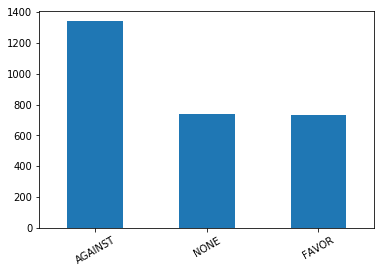

In [0]:
train_orig.Stance.value_counts().plot.bar(rot=30);

In [0]:
print("SemEval 2016 Task 6 (subtask A) Tweet topics are:\n")
print("------------------------------------------")
for item in train_orig.Target.unique():
    print(item)

SemEval 2016 Task 6 (subtask A) Tweet topics are:

------------------------------------------
Atheism
Climate Change is a Real Concern
Feminist Movement
Hillary Clinton
Legalization of Abortion


**Apply the cleaning function to the 'Tweet' column of the training data**

In [0]:
train_orig['Tweet'] = train_orig['Tweet'].apply(clean_ascii)

In [0]:
train_orig.head()

,ID,Target,Tweet,Stance
0,101,Atheism,dear lord thank u for all of ur blessings forg...,AGAINST
1,102,Atheism,"Blessed are the peacemakers, for they shall be...",AGAINST
2,103,Atheism,I am not conformed to this world. I am transfo...,AGAINST
3,104,Atheism,Salah should be prayed with #focus and #unders...,AGAINST
4,105,Atheism,And stay in your houses and do not display you...,AGAINST


**Store the relevant information from training data**

ULMFit requires just the stance and the text data (i.e. tweets) for the language-model finetuning and classification steps, hence these are stored in a DataFrame.

In [0]:
train = pd.concat([train_orig['Stance'], train_orig['Tweet']], axis=1)
train.tail()

,Stance,Tweet
2809,AGAINST,"There's a law protecting unborn eagles, but no..."
2810,AGAINST,I am 1 in 3... I have had an abortion #Abortio...
2811,AGAINST,How dare you say my sexual preference is a cho...
2812,AGAINST,"Equal rights for those 'born that way', no rig..."
2813,AGAINST,#POTUS seals his legacy w/ 1/2 doz wins. The #...


#4. Experimental Setup

Stance detection uses a semi-supervised approach where we reuse weights from a pretrained language model (in this case wikitext-103) and perform multi-class classification on the training data over the three classes (FAVOR, AGAINST and NONE).

Evaluation
The metric used to score the stance classification is F-score. The event organizers provide an [evaluation script](http://alt.qcri.org/semeval2016/task6/index.php?id=data-and-tools) that calculates the macro-average of F-score (FAVOR) and F-score (AGAINST) for task A. This compares our model's predicted stance for each Tweet against the gold reference.

The perl script provided by the organizers is used to generate an F- score. The evaluation script is in data/eval/ and has the following usage:

```
cd data/eval
perl eval.pl -u

---------------------------
Usage:
perl eval.pl goldFile guessFile

goldFile:  file containing gold standards;
guessFile: file containing your prediction.

```

In [0]:
!wget http://alt.qcri.org/semeval2016/task6/data/uploads/eval_semeval16_task6_v2.zip

--2019-06-02 01:17:20--  http://alt.qcri.org/semeval2016/task6/data/uploads/eval_semeval16_task6_v2.zip
Resolving alt.qcri.org (alt.qcri.org)... 13.93.27.76
Connecting to alt.qcri.org (alt.qcri.org)|13.93.27.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7404 (7.2K) [application/zip]
Saving to: ‘eval_semeval16_task6_v2.zip’

eval_semeval16_task 100%[===================>]   7.23K  --.-KB/s    in 0s      

2019-06-02 01:17:20 (623 MB/s) - ‘eval_semeval16_task6_v2.zip’ saved [7404/7404]



In [0]:
!unzip eval_semeval16_task6_v2.zip -d {path}

Archive:  eval_semeval16_task6_v2.zip
   creating: /content/data/twitter/eval_semeval16_task6_v2/
  inflating: /content/data/twitter/eval_semeval16_task6_v2/.DS_Store  
   creating: /content/data/twitter/__MACOSX/
   creating: /content/data/twitter/__MACOSX/eval_semeval16_task6_v2/
  inflating: /content/data/twitter/__MACOSX/eval_semeval16_task6_v2/._.DS_Store  
  inflating: /content/data/twitter/eval_semeval16_task6_v2/eval.pl  
  inflating: /content/data/twitter/__MACOSX/eval_semeval16_task6_v2/._eval.pl  
  inflating: /content/data/twitter/eval_semeval16_task6_v2/gold_toy.txt  
  inflating: /content/data/twitter/__MACOSX/eval_semeval16_task6_v2/._gold_toy.txt  
  inflating: /content/data/twitter/eval_semeval16_task6_v2/guess_toy.txt  
  inflating: /content/data/twitter/__MACOSX/eval_semeval16_task6_v2/._guess_toy.txt  
  inflating: /content/data/twitter/eval_semeval16_task6_v2/guess_toy_unix.txt  
  inflating: /content/data/twitter/__MACOSX/eval_semeval16_task6_v2/._guess_toy_unix.t

**Reference result**

To have a benchmark to compare our results against, it makes sense to look at the winning paper for this shared task, from team MITRE, who published their methodology and approach. From this paper, it can be seen that MITRE used an LSTM-based deep learning approach and performed per-topic classification of Tweets to achieve an average macro F-score of 0.67.

**Stance Prediction**

The predicted output stances on the test dataset is written out according to the format expected by the evaluation perl script, and the F-scores are published as per this evaluation.

#5. Transfer Learning Stages

This notebook utilizes the refactored and updated version (v1) of ULMFit as implemented in the fastai GitHub repository. This requires an install of Pytorch 1.0.0 (released on December 7, 2018) to run since its development intended to move alongside PyTorch's own development cycle in the future. It is recommended to run this entire notebook in a virtual environment to avoid clashes with pre-existing installs of PyTorch.

The refactored code for ULMFit is much more high-level and abstracted than the original version that was used in the paper, so it doesn't make sense to rewrite the data manipulation code for text handling and tokenization from the ground up. We can take advantage of the powerful transfer learning functionality that is baked into ULMFit (obtained after months of fine-tuning and refactoring the source code by Fast.ai) instead!

#5.1 Language model finetuning: (SemEval Tweets only)

The pre-trained language model used is from this work by Merity et al.. Although we are working with Twitter whose content's structure that can be quite dissimilar to Wikipedia's sentence formulation, the hope is that the language understanding developed by the model, in combination with the fine-tuning techniques described in Howard and Ruder's paper, will allow us to at least transfer some knowledge for the purposes of classification of Tweet stance.

##Preprocess data for language model fine-tuning

The TextLMDataBunch [source](https://docs.fast.ai/text.data.html#TextLMDataBunch) class returns a "Databunch" type of object that is a custom object defined in fastai.text's API. Note that according to this class definition, a significant amount of data pre-processing is going on under the hood.

- Initialize the language model with the pre-trained vocabulary's weights
- Create a custom data loader that "batchifies" the target task's vocabulary, i.e. split it up into batches for processing on the GPU
- Introduce randomness into the batches, but without breaking up the sentence sequences using techniques [borrowed from language modeling](https://arxiv.org/pdf/1708.02182.pdf).
- Tokenize the target task's vocabulary and increase the efficiency of tokenization (for large tasks) using multi-threading

In [0]:
data_lm = (TextList.from_df(train_orig,path,cols='Tweet')
          .split_by_rand_pct(0.1)
          .label_for_lm()
          .databunch(bs=32))
          

In [0]:
# Language model data
#data_lm = TextLMDataBunch.from_df(train_orig,path,cols='Tweet', min_freq=1)

Note that in this case, we specify a minimum word frequency of 1 (i.e. words that appear just once in the data are given the tag <unk> during tokenization.

In [0]:
#??TextLMDataBunch

In [0]:
# Save the language and classifier model data for re-use
data_lm.save('data_lm.pkl')

In [0]:
data_lm.show_batch()

idx,text
0,"xxunk of my mind . # xxunk # xxmaj god # 2014 # semst xxbos xxmaj and stay in your xxunk and do not xxunk yourselves like that of the times of ignorance . "" [ xxmaj quran xxunk ] . # islam # semst xxbos xxmaj if we are xxunk whether something is xxunk or xxunk , we should leave it - this will # xxunk our # xxunk"
1,"you perfectly . # semst xxbos xxunk xxmaj you are quite xxunk . :) / xxunk xxunk # semst xxbos xxmaj every time i arrive at my home , i 'm n constant xxunk of how much my xxmaj god loves me xxunk family is better than xxunk . i xxup love xxup my xxup life # xxmaj blessed # semst xxbos i have been xxunk with xxmaj christ &"
2,"still and forever will ever be , always in control . # xxup xxunk # semst xxbos xxup rt @prayerbullets : xxmaj let the xxunk of xxmaj your kingdom be released xxunk . xxunk # semst xxbos xxup rt @prayerbullets : xxmaj let the xxunk of my life and city be opened for the xxmaj king of xxunk to come in -ps . xxunk # semst xxbos xxmaj let us"
3,"xxunk makes clear xxmaj america is xxup not a xxmaj christian nation # semst xxbos xxunk i can see why it 's xxunk lol # lovewins # xxunk # semst xxbos xxmaj just because the xxmaj supreme xxmaj court xxunk something , does n't make anything equal . xxmaj equality , like anything else , is matter of the heart . # semst xxbos xxmaj today i am glad to"
4,"any xxmaj xxunk xxmaj american goes to church , they should realize that their make believe god supported their slavery . # semst xxbos xxmaj before going to church , xxmaj xxunk xxmaj americans should realize that their make believe god supported slavery . # xxunk # semst xxbos xxmaj take hold of your xxmaj authority in xxmaj christ ! xxmaj take back what the enemy has xxunk ! #"


On viewing the tokenized Tweets, we can see that they look markedly different from their original form. The tokenization technique used by fastai.text is quite advanced and obtained [after months of development by Jeremy Howard and the fastai team](https://github.com/cedrickchee/knowledge/blob/master/courses/fast.ai/deep-learning-part-2/2018-edition/lesson-10-transfer-learning-nlp.md), and thus uses quite a few tricks to capture semantic meaning from the text.

Note that **we are not converting the text to lowercase and removing stopwords (which was a common pre-tokenization approach in NLP until recently) — this would result in a tremendous loss of information** that the model could instead use to gather an understanding of the new task's vocabulary. Instead, a number of added tags are applied to each word as shown above so that minimal information is lost. All punctuation, hashtags and special characters are also retained.

For example, the **xxmaj** token [source] indicates that there is capitalization of the word. "The" will be tokenized as "**xxmaj the**". Words that are fully capitalized, such as "I AM SHOUTING", are tokenized as "**xxup i xxup am xxup shouting**". The method still uses [spaCy's underlying tokenizer](https://spacy.io/usage/spacy-101#annotations-token) (including a multi-thread wrapper around spaCy to speed things up), but adds tags in a very smart way . This balances capturing semantic meaning with reducing the number of overall tokens — so it is both powerful and efficient. For a full list of all the token tags generated by ULMFiT’s fastai implementation, see the [source code here](https://github.com/fastai/fastai/blob/4cd2e454a735e208c60b2ff7f82bbb4b62e85725/fastai/text/transform.py#L19)

.

In [0]:
learn = language_model_learner(data_lm,AWD_LSTM,drop_mult=0.3)

##Print the structure of the language model RNN

We can examine the architecture of the 3-layer LSTM used in ULMFit as shown below. For the language model fine-tuning, we define the embeddings based on the the target task vocabulary size. A single linear output layer is defined that updates the weights once we pass the input through the network.

In [0]:
list(learn.model.children())

[AWD_LSTM(
   (encoder): Embedding(1860, 400, padding_idx=1)
   (encoder_dp): EmbeddingDropout(
     (emb): Embedding(1860, 400, padding_idx=1)
   )
   (rnns): ModuleList(
     (0): WeightDropout(
       (module): LSTM(400, 1150, batch_first=True)
     )
     (1): WeightDropout(
       (module): LSTM(1150, 1150, batch_first=True)
     )
     (2): WeightDropout(
       (module): LSTM(1150, 400, batch_first=True)
     )
   )
   (input_dp): RNNDropout()
   (hidden_dps): ModuleList(
     (0): RNNDropout()
     (1): RNNDropout()
     (2): RNNDropout()
   )
 ), LinearDecoder(
   (decoder): Linear(in_features=400, out_features=1860, bias=True)
   (output_dp): RNNDropout()
 )]

##Find the optimum learning rate

We define a learner object that uses the tokenized language model data, that is organized into batches for the GPU, and feed it a pre-trained language model as follows. [**fastai.train**](https://github.com/fastai/fastai/blob/050080be574cb1260462bbd03e9600e43e7a54b1/fastai/train.py#L23) provides a convenient utility to search through a range of learning rates to find the optimum one for our dataset. The idea is that our optimization function needs to use a learning rate that is at least an order of magnitude below the point at which the loss starts to diverge.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02


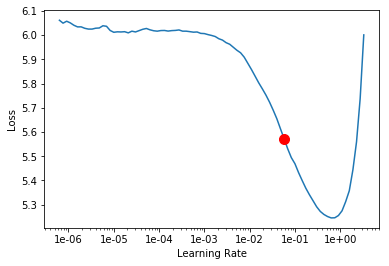

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

##Run the language_model_learner class

The pre-trained language model quickly downloads from the fastai's AWS link, so there is no need to download it separately. [drop_mult] is the multiplier applied to the dropout in the language learner. As per the ULMFit paper, we use a custom dropout for each language model layer, and the drop_multjust scales [a numpy array of these dropouts](https://github.com/fastai/fastai/blob/1c5c007e10a187f4a048a3ee8137016534259768/fastai/text/learner.py#L15) which remain in the same relative ratio to one another. These numbers have been obtained through empirical tuning for a range of language tasks, and we took note of this during our extensive reading on this task.

In [0]:
learn.fit_one_cycle(5,1e-1,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.510616,3.537758,0.317634,00:03
1,4.016086,3.669082,0.313616,00:03
2,3.759998,3.587425,0.324107,00:03
3,3.451572,3.515171,0.335826,00:03
4,3.138628,3.512726,0.336496,00:03


In [0]:
learn.save('stage-1')

##Unfreeze the entire model

To train the language model during fine-tuning, we unfreeze all the layers and then perform training for a reasonable time until we obtain a low enough validation loss. For a larger target vocabulary, these hyperparameters might need to be modified, and the training time would be significantly longer, but for this SemEval task, we have a very small additional vocabulary to fine-tune the language model on, so it is really quick.

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(20,max_lr=1e-3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.713761,3.516617,0.335491,00:04
1,2.696316,3.518044,0.336384,00:04
2,2.657013,3.526532,0.337500,00:04
3,2.593151,3.548536,0.337723,00:04
4,2.500762,3.589635,0.335938,00:04
5,2.372510,3.652645,0.340067,00:04
6,2.214453,3.738857,0.336384,00:04
7,2.046955,3.848619,0.332701,00:04
8,1.879838,3.949362,0.332478,00:04
9,1.714730,4.096389,0.323549,00:04


##Revise drop_mult = 0.5

In [0]:
learn = language_model_learner(data_lm,AWD_LSTM,drop_mult=0.5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-02


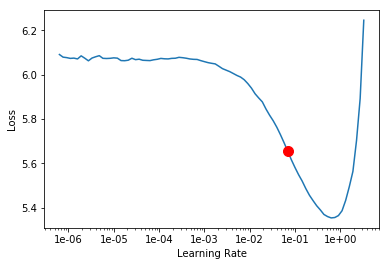

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(5,max_lr=1e-2,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.599284,4.428317,0.251228,00:03
1,4.635528,3.472047,0.322098,00:03
2,4.068678,3.368303,0.335938,00:03
3,3.752622,3.337893,0.340290,00:03
4,3.559715,3.342294,0.338839,00:03


In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(20,max_lr=1e-3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.306420,3.311434,0.344196,00:04
1,3.292441,3.268511,0.349665,00:04
2,3.247681,3.229843,0.358147,00:04
3,3.178439,3.213605,0.359933,00:04
4,3.091782,3.186364,0.361384,00:04
5,2.999836,3.206648,0.358147,00:04
6,2.882473,3.203842,0.358929,00:04
7,2.752206,3.233735,0.356250,00:04
8,2.618445,3.252793,0.358371,00:04
9,2.476423,3.317188,0.354911,00:04


In [0]:
# save the fined-tune encoder
learn.save_encoder('ft_enc')

# 5.2 Train the Classifier: SemEval Tweets only


For classification, the winning paper for the SemEval 2016 task (team MITRE) describe in section $5$ of their paper that they achieved their highest average F1 score when they trained 5 distinct classifiers, i.e. a separate training task for each of the 5 topics in the training data.

Hence, in this notebook we only perform classification for one topic at a time. Evaluation of the predicted classes is also done on a per-topic basis.

## Identify the 5 topics in our training data

In [0]:
for item in train_orig.Target.unique():
    print(item)

Atheism
Climate Change is a Real Concern
Feminist Movement
Hillary Clinton
Legalization of Abortion


## Specify the topic we want to classify for

We specify the topic name exactly as the training data does, and use it to subset the Pandas DataFrame.



In [0]:
topic = "Feminist Movement"

In [0]:
# get only thoses tweets that pertains to single topic in the training data
train_topic=train_orig.loc[train_orig.Target==topic]

In [0]:
train_topic.head()

,ID,Target,Tweet,Stance
908,1009,Feminist Movement,Always a delight to see chest-drumming alpha m...,FAVOR
909,1010,Feminist Movement,Sometimes I overheat and want to take off my s...,FAVOR
910,1011,Feminist Movement,If feminists spent 1/2 as much time reading pa...,AGAINST
911,1012,Feminist Movement,"Stupid Feminists, the civilization you take fo...",AGAINST
912,1013,Feminist Movement,YOU'RE A GIRL AND HAVE A SEX DRIVE!? YOU MUST ...,FAVOR


## Create classification dataloader

This step involves creating a [classifier object](https://github.com/fastai/fastai/blob/4cd2e454a735e208c60b2ff7f82bbb4b62e85725/fastai/text/learner.py#L146) that can predict a class label once we re-train the model as a classifier. The same network structure is still used for this task — the output layer is defined in a way that takes into account the number of classes we want to predict in our data.

In [0]:
data_cls = (TextList.from_df(train_topic,path,cols='Tweet',vocab=data_lm.vocab)
           .split_subsets(train_size=0.7,valid_size=0.3)
           .label_from_df(cols='Stance')
           .databunch(bs=48))

In [0]:
data_cls.save('data_cls.pkl')

In [0]:
data_cls.show_batch()

text,target
"xxbos m : xxup feminists xxup need xxup to xxup xxunk xxup sense xxup of xxup xxunk w : xxmaj okay . ( xxunk from "" xxmaj male xxmaj tears "" xxunk ) m : xxup xxunk ! xxup xxunk xxrep 11 xxunk # yesallwomen # semst",AGAINST
"xxbos * watching house of xxunk with my dad * "" i could be xxmaj first xxmaj lady . "" "" xxmaj why not president ? "" "" xxup yeah xxup dad ! xxmaj next woman president right here ! "" # semst",FAVOR
xxbos xxunk : ... xxup or xxup xxunk xxup down xxup your xxup car xxup to xxup xxunk xxup at xxup me xxup while i xxup wait xxup for xxup the xxup bus ! ! ! # xxup xxunk # semst,AGAINST
xxbos ... xxup or xxup xxunk xxup down xxup your xxup call xxup to xxup xxunk xxup at xxup me xxup while i xxup wait xxup for xxup the xxup bus ! ! ! # xxup xxunk # semst,AGAINST
"xxbos xxmaj there is one more basic cause [ of the abuse of women ] , and that is that , in general , men do n't give a damn . ( xxmaj xxunk xxmaj xxunk ) # semst",AGAINST


In [0]:
learn = text_classifier_learner(data_cls,AWD_LSTM,drop_mult=0.5,metrics=[FBeta(average='macro'),accuracy])
learn.load_encoder('ft_enc')
learn.freeze()

Note that we begin the training with all the outer layers as frozen. The fine-tuned language model is read in, and we use a dropout multiplier as shown above.

For training the classifier, we apply "gradual unfreezing", to avoid "catastrophic forgetting" as explained in section $3.3$ of [Howard and Ruder's paper](https://arxiv.org/pdf/1801.06146.pdf). In addition to gradual unfreezing,

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-02


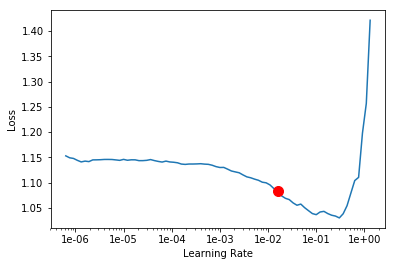

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

## Carefully train the classifier

During classification, we first define a classifier learner object, and **gradually unfreeze layers** while running for one epoch each time as per the ULMFiT paper’s suggestion. This helps us obtain a better classification accuracy than if we were to aggressively train all the layers at once.

In [0]:
learn.fit_one_cycle(5,max_lr=1e-2,moms=(0.8,0.7))

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,1.142061,1.064839,0.325351,0.396985,00:00
1,1.070687,0.961404,0.316883,0.522613,00:00
2,1.007026,0.930145,0.309379,0.527638,00:00
3,0.952303,0.909401,0.369546,0.527638,00:00
4,0.911635,0.895186,0.444491,0.552764,00:00


In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(5,max_lr=1e-2,moms=(0.8,0.7))

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.811623,0.914729,0.509967,0.567839,00:00
1,0.837206,1.104998,0.324891,0.532663,00:00
2,0.821463,0.919123,0.450544,0.552764,00:00
3,0.770898,0.941581,0.468885,0.547739,00:00
4,0.728187,0.956921,0.475920,0.567839,00:00


In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(5,max_lr=1e-2,moms=(0.8,0.7))

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.602165,1.041005,0.523971,0.562814,00:00
1,0.620487,1.374031,0.415256,0.467337,00:00
2,0.562261,1.130226,0.510937,0.567839,00:00
3,0.473389,1.221065,0.479738,0.542714,00:00
4,0.398465,1.196076,0.460584,0.517588,00:00


In [0]:
learn.unfreeze()
learn.fit_one_cycle(5,max_lr=1e-2,moms=(0.8,0.7))

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.177258,1.574277,0.457426,0.497487,00:01
1,0.494790,1.423974,0.381592,0.371859,00:01
2,0.664719,1.047753,0.446829,0.437186,00:01
3,0.738807,0.997071,0.470153,0.482412,00:01
4,0.757416,0.937103,0.535383,0.542714,00:01


The validation loss for the classifier is much higher than for the language model, which could possibly be linked with the dataset. Since there is significant class imbalance, a significant number of labels during training are expected to be predicted incorrectly. Specific to this Twitter dataset, this problem could be more severe than what we see in the state-of-the-art examples (such as IMDb).

## Cross-tabulate the predictions for each class

The below table shows the predicted classes for the topic in concern. The actual evaluation of the F1 score of the classification result is done at a later step.

In [0]:
#get predictions
preds,targets = learn.get_preds()
predictions = np.argmax(preds,axis=1)


In [0]:
preds[:5],predictions[:5]

(tensor([[0.4609, 0.2369, 0.3022],
         [0.6626, 0.3052, 0.0322],
         [0.4726, 0.2834, 0.2440],
         [0.2306, 0.4879, 0.2816],
         [0.3593, 0.6016, 0.0392]]), tensor([0, 0, 0, 1, 1]))

In [0]:
targets[:5]

tensor([0, 0, 0, 1, 0])

In [0]:
pd.crosstab(predictions,targets)

col_0,0,1,2
row_0,,,
0,57,16,5
1,23,23,8
2,22,17,28


## Evaluate the predicted results from the classifier (SemEval tweets only)

We read in the test dataset and store in a Pandas DataFrame as shown.

In [0]:
test = pd.read_csv(f'{path}/{testfile}',delimiter='\t',header=0,encoding='latin-1')
test = test.drop(['ID'],axis=1)
test.Tweet = test.Tweet.apply(clean_ascii)
test.head()

,Target,Tweet,Stance
0,Atheism,He who exalts himself shall be humbled; a...,UNKNOWN
1,Atheism,RT @prayerbullets: I remove Nehushtan -previou...,UNKNOWN
2,Atheism,@Brainman365 @heidtjj @BenjaminLives I have so...,UNKNOWN
3,Atheism,#God is utterly powerless without Human interv...,UNKNOWN
4,Atheism,@David_Cameron Miracles of #Multiculturalism...,UNKNOWN


Since we do not yet know the stance for the test set, it is marked as "UNKNOWN".

## Filter the test data set based on topic we are classifying for

In [0]:
test_pred = test[['Target','Tweet']]
test_pred = test_pred.loc[test_pred.Target==topic]
test_pred.tail()

,Target,Tweet
669,Feminist Movement,@Maisie_Williams is our hero with her #LikeAGi...
670,Feminist Movement,"Rather be an ""ugly"" feminist then be these sad..."
671,Feminist Movement,iamNovaah: RT ChrzOC: Bitches be running wild....
672,Feminist Movement,@angerelle you disagree that people should str...
673,Feminist Movement,#Rapeculture is basically a FABLE. It has almo...


##Apply the learner's predict method to produce our prediction



In [0]:
test_pred['Stance']= test_pred['Tweet'].apply(lambda row: str(learn.predict(row)[0]))

In [0]:
test_pred.tail()

,Target,Tweet,Stance
669,Feminist Movement,@Maisie_Williams is our hero with her #LikeAGi...,AGAINST
670,Feminist Movement,"Rather be an ""ugly"" feminist then be these sad...",AGAINST
671,Feminist Movement,iamNovaah: RT ChrzOC: Bitches be running wild....,NONE
672,Feminist Movement,@angerelle you disagree that people should str...,NONE
673,Feminist Movement,#Rapeculture is basically a FABLE. It has almo...,AGAINST


##Output the predicted dataset to a text file for comparison with the gold reference

First, we get the test data with gold label as below. Using the subtask A to be in line with test data above

In [0]:
!wget http://alt.qcri.org/semeval2016/task6/data/uploads/semeval2016-task6-testdata-gold.zip
!unzip semeval2016-task6-testdata-gold.zip -d {path}eval_semeval16_task6_v2/

--2019-06-02 01:22:23--  http://alt.qcri.org/semeval2016/task6/data/uploads/semeval2016-task6-testdata-gold.zip
Resolving alt.qcri.org (alt.qcri.org)... 13.93.27.76
Connecting to alt.qcri.org (alt.qcri.org)|13.93.27.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100108 (98K) [application/zip]
Saving to: ‘semeval2016-task6-testdata-gold.zip’

semeval2016-task6-t 100%[===================>]  97.76K   454KB/s    in 0.2s    

2019-06-02 01:22:23 (454 KB/s) - ‘semeval2016-task6-testdata-gold.zip’ saved [100108/100108]

Archive:  semeval2016-task6-testdata-gold.zip
  inflating: /content/data/twitter/eval_semeval16_task6_v2/SemEval2016-Task6-subtaskA-testdata-gold.txt  
  inflating: /content/data/twitter/eval_semeval16_task6_v2/SemEval2016-Task6-subtaskB-testdata-gold.txt  


Second, we filter it with topic "Feminist Movement"

In [0]:
test_gold = pd.read_csv(f'{path}/eval_semeval16_task6_v2/SemEval2016-Task6-subtaskA-testdata-gold.txt',delimiter='\t',header=0,encoding='latin-1')
test_gold = test_gold.drop(['ID'],axis=1)
test_gold = test_gold.loc[test_gold.Target==topic]

In [0]:
test_gold.head()

,Target,Tweet,Stance
389,Feminist Movement,Feminists can TOTALLY wear makeup and don't te...,AGAINST
390,Feminist Movement,"I searched for posts with ""feminist"" tag and s...",AGAINST
391,Feminist Movement,I saw a little girl wearing a mustache from th...,AGAINST
392,Feminist Movement,Women are taught to put their values into thei...,AGAINST
393,Feminist Movement,If u link anti feminism with misogyny or inequ...,AGAINST


In [0]:
test_gold.to_csv(f'{path}eval_semeval16_task6_v2/target.txt',sep='\t',index=True,
                 header=['Target','Tweet','Stance'],index_label='ID')

In [0]:
test_pred.head()

,Target,Tweet,Stance
389,Feminist Movement,Feminists can TOTALLY wear makeup and don't te...,AGAINST
390,Feminist Movement,"I searched for posts with ""feminist"" tag and s...",AGAINST
391,Feminist Movement,I saw a little girl wearing a mustache from th...,FAVOR
392,Feminist Movement,Women are taught to put their values into thei...,FAVOR
393,Feminist Movement,If u link anti feminism with misogyny or inequ...,AGAINST


In [0]:
test_pred.to_csv(f'{path}eval_semeval16_task6_v2/prediction.txt',sep='\t',index=True,
                 header=['Target','Tweet','Stance'],index_label='ID')

Once we have the predicted data and target data, we use the perl script provided by the SemEval organizers to generate the F1 score.

The evaluation script is in `data/twitter/eval_semeval16_task6_v2/eval.pl`   and has the following usage:

In [0]:
!perl /content/data/twitter/eval_semeval16_task6_v2/eval.pl /content/data/twitter/eval_semeval16_task6_v2/target.txt  /content/data/twitter/eval_semeval16_task6_v2/prediction.txt



Results				 
FAVOR     precision: 0.2941 recall: 0.3448 f-score: 0.3175
AGAINST   precision: 0.7557 recall: 0.5410 f-score: 0.6306
------------
Macro F: 0.4740



Using a relatively small input vocabulary from the Twitter training data, we do not do that well in the F-score for the "Feminist Movement" topic. On trying out a similar approach for Tweets from the other topics (Atheism, Hillary Clinton, etc.), we still do not see an F-score of above 0.60 - this is well below the winning score by MITRE of 0.67.

To improve the score, some more fine-tuning is needed.

# 5.3 Best model parameters using ULMFiT

The best average macro F-score of 0.65 using ULMFiT across all topics was obtained using the below approach and parameters:

- Fine-tuning the language model on an augmented Twitter vocabulary: this was done by downloading the Twitter sentiment140 dataset from Kaggle, and feeding a subset of its vocabulary (200,000 words) to the language model fine-tuning step. The steps for this are shown in detail the Jupyter notebook ulmfit.ipynb. The full Kaggle Twitter dataset has 1.6 million Tweets, which would have taken several hours to fine-tune the language model on (even on an NVIDIA P100 GPU) — so only a subset of 200,000 words were used to augment the language model fine-tuning step.

- Training 5 distinct classifiers (i.e. a separate training task for each topic during classification) and then combining the outputs for comparison with the gold reference— this was a technique similar to that used by MITRE in their best result from 2016, and is explained in their paper.

- An optimum learning rate of 1e-03 for the language model fine-tuning step

- An optimum learning rate in the range of 1e-05 to 1e-03 for the classifier, with gradual unfreezing

# 5.3 Train the Classifier: Augmented Vocabulary

Since the initial approach (despite multiple attempts at fine-tuning both the language model and the classifier) did not generate an F-score as high as MITRE's (which was ~0.67), it can be reasoned that this could be because the pre-trained language model did not generalize to Tweets specifically (since the language syntax of tweets are quite different than the Wikipedia text that the LSTMs were trained on).

The provided training data of 2,800 Tweets can be augmented with the [Kaggle Twitter Sentiment140 dataset](https://www.kaggle.com/kazanova/sentiment140) of 1.6 million tweets. By fine-tuning the language model on this larger Twitter dataset, we might better learn the structure of Twitter conversations.

NOTE: Since 1.6 million tweets is quite a large dataset and can add a significant number of unique, one-time-only words, in this notebook, we only sampled a subset of 200,000 from the original Sentiment140 dataset for the language model fine-tuning to save on language model fine-tuning time. It is possible that fine-tuning the language model with a larger subset of the augmentation vocabulary could further improve the language model fine-tuned results.

In [0]:
!pip install kaggle
!mkdir .kaggle

import os
import json 
token = {"username":"hduongck","key":"983e2ab1fbb29cf2734bcbf8811d42fb"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

#os.makedirs('/data/kaggle/', exist_ok=True)
os.makedirs('/.kaggle/',exist_ok=True) 
!chmod 600 /content/.kaggle/kaggle.json

!kaggle config set -n path -v{/content/data}


!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle datasets download -d kazanova/sentiment140 -p /content/data/twitter


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 6, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
 87% 73.0M/84.0M [00:00<00:00, 69.9MB/s]
100% 84.0M/84.0M [00:00<00:00, 102MB/s] 


In [0]:
!unzip /content/data/twitter/sentiment140.zip -d {path}

Archive:  /content/data/twitter/sentiment140.zip
  inflating: /content/data/twitter/training.1600000.processed.noemoticon.csv  


In [0]:
# Load Kaggle Twitter Dataset
kaggle = pd.read_csv(f'{path}training.1600000.processed.noemoticon.csv',header=None,encoding='latin-1')
kaggle.columns =['col1','col2','col3','Stance','col5','Tweet']

In [0]:
kaggle.head()

,col1,col2,col3,Stance,col5,Tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [0]:
# keep the cols we need
kaggle=kaggle[['Stance','Tweet']]

In [0]:
kaggle.shape

(1600000, 2)

In [0]:
# Clean Data and Remove URL's from the tweets

kaggle['Tweet'] = kaggle['Tweet'].apply(clean_ascii)
kaggle['Tweet'] = kaggle['Tweet'].replace(r'http\S+','',regex=True)
kaggle_sub = kaggle.sample(n=200000,random_state=77)
kaggle_sub = kaggle.append(train,ignore_index=True)

## Twitter Language Learner

In [0]:
twitter_lm = (TextList.from_df(kaggle_sub,path,cols='Tweet')
             .split_by_rand_pct(0.1)
             .label_for_lm()
             .databunch(bs=64))
twitter_lm.save('kaggle_lm')

In [0]:
twitter_lm.show_batch()

idx,text
0,"managed to save 50 % xxmaj the rest go out of bounds xxbos my whole body feels itchy and like its on fire xxbos @nationwideclass no , it 's not behaving at all . i 'm mad . why am i here ? because i ca n't see you all over there . xxbos xxunk not the whole crew xxbos xxmaj need a hug xxbos xxunk hey long time no"
1,"too early for a sunday stupid father daughter time ! ! xxbos starving but there s no good food here xxbos xxunk not good , xxunk off tom again lol . 10 days til payday xxbos xxup xxunk strikes again i 'm too miserable to party so gave it a miss xxbos xxunk xxunk where do u guys get this endless xxup xxunk from ? xxmaj lawd , i still"
2,". xxbos @tatiny ca n't wait to watch casual friday ! then one more episode before the season breaks xxbos i 'm at work with my xxup b. xxmaj but i 'm so ready to go home and crawl back into bed and go back to sleep ... ugh stuck here till 2 ! ! xxbos goin' back to work xxmaj monday .. bittersweet . xxmaj miss my students ,"
3,"feel muc xxrep 4 h worse . xxmaj about to start working , one more page to go . xxbos ca n't move . trying to get out of bed ... i have a new found respect for strippers . xxbos xxmaj very windy , xxmaj dusty & & xxmaj cloudy day ... xxmaj pls end fast xxbos @irishjonasfan xxmaj psssh one is being made to go on a bike"
4,"@davidarchie aww xxmaj danny xxmaj gokey was voted off i actually want him to be in the finals .. xxbos xxunk ke man az xxunk xxunk xxunk xxunk xxunk dare , xxunk xxunk hey xxunk xxunk xxbos it 's too early xxbos so ti xxrep 6 r ed and reallly not in the mood for school either .. xxbos xxup btw ... who put glue on the clock hands ?"


In [0]:
learn_twitter = language_model_learner(twitter_lm,AWD_LSTM,drop_mult=0.5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-02


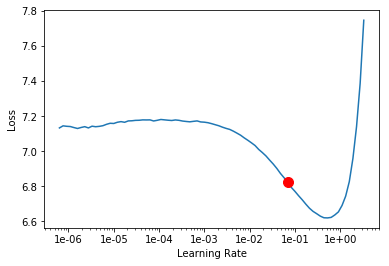

In [0]:
learn_twitter.lr_find()
learn_twitter.recorder.plot(suggestion=True)

In [80]:
gc.collect()

887945

In [82]:
learn_twitter.fit_one_cycle(5,max_lr=1e-3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.576567,4.423285,0.228360,43:33
1,4.592129,4.424795,0.228380,43:43


KeyboardInterrupt: ignored

In [0]:
learn_twitter.save_encoder('ft_enc_encoder_v1')

In [0]:
#Save the Vocab to a Pickle file for later use
pickle.dump(twitter_lm.train_ds.vocab,open(f'{path}vocab.pkl','wb'))

**Load Vocabulary**

This assumes that we have a fine-tuned language model's numericalized vocabulary vocab.pkl in the same directory as the notebook.

In [0]:
vocab_load = pickle.load(open(f'{path}vocab.pkl','rb'))

##Text classifier on all multiple topic

Various values of momentum, dropout and learning rates were tried to find the best values of these parameters. The below parameters are applied in a for loop to train on each topic one by one, and then appending the predictions to a common file for comparison with the gold reference.

In [0]:
preds_document=pd.DataFrame()

(280, 2)


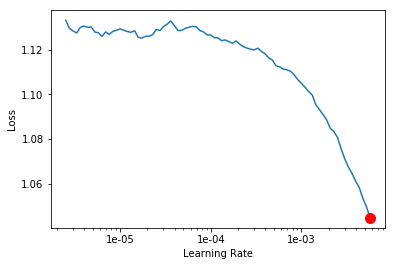

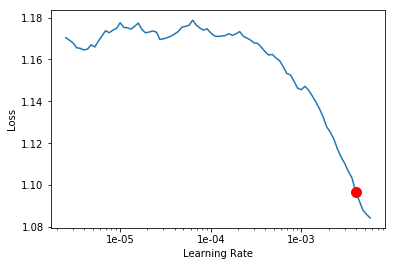

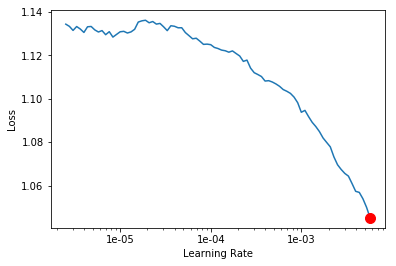

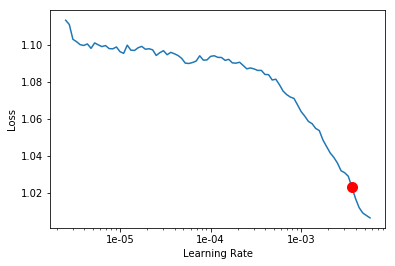

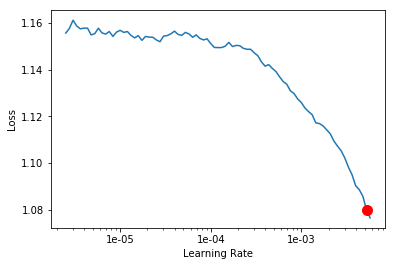

In [107]:
for topic in train_orig.Target.unique():
    print('Topic: ',topic)
    train_topic = train.loc[train_orig.Target==topic]
    
    #classifier model data
    data_cls = (TextList.from_df(train_topic,path,cols='Tweet',vocab=vocab_load)
               .split_by_rand_pct(0.2)
               .label_from_df(cols='Stance')
               .databunch(bs=64))
    data_cls.save()
    learn = text_classifier_learner(data_cls,AWD_LSTM,drop_mult=0.5,metrics=[FBeta(average='macro'),accuracy])
    learn.load_encoder('ft_enc_encoder_v1')
    learn.freeze()
    
    #find optimum learning rate
    learn.lr_find(start_lr=1e-6,end_lr=1e-2)
    learn.recorder.plot(suggestion=True)
    
    #Train the classifier by gradually unfreezing the layers
    learn.fit_one_cycle(3,max_lr=1e-3,moms=(0.8,0.7))
    #Unfreeze the layer
    learn.freeze_to(-2)
    learn.fit_one_cycle(3,max_lr=1e-3,moms=(0.8,0.7))
    #Unfreeze the layer
    learn.freeze_to(-3)
    learn.fit_one_cycle(3,max_lr=1e-3,moms=(0.8,0.7))
    #Unfreeze all layers
    learn.unfreeze()
    learn.fit_one_cycle(5,max_lr=1e-3,moms=(0.8,0.7))
    
    #get predictions
    preds,targets= learn.get_preds()
    predictions = np.argmax(preds,axis=1)
    pd.crosstab(predictions,targets)
    
    #filter test_topic
    test_pred = test[['Target','Tweet']]
    test_pred = test_pred.loc[test_pred.Target==topic]
    print(test_pred.shape)
    
    #get predictions on test_topic
    test_pred['Stance'] = test_pred['Tweet'].apply(lambda row: str(learn.predict(row)[0]))
    file_to_save = "predicted_"+str(topic.replace(" ","_"))+".txt"
    test_pred.to_csv(f'{path}eval_semeval16_task6_v2/{file_to_save}',sep='\t', index=True,
                     header=['Target', 'Tweet', 'Stance'], index_label='ID')
   
    if topic =='Atheism':
        preds_document=test_pred
    else: 
        preds_document = preds_document.append(test_pred,ignore_index=True)
    

##Output the predicted dataset to a text file for comparison with the gold reference

In [0]:
test_gold = pd.read_csv(f'{path}/eval_semeval16_task6_v2/SemEval2016-Task6-subtaskA-testdata-gold.txt',delimiter='\t',header=0,encoding='latin-1')

In [108]:
test_gold.shape,preds_document.shape

((1249, 4), (1249, 3))

In [0]:
preds_document.to_csv(f'{path}eval_semeval16_task6_v2/all_prediction.txt',sep='\t',index=True,
                        header=['Target','Tweet','Stance'],index_label='ID')

In [110]:
!perl /content/data/twitter/eval_semeval16_task6_v2/eval.pl /content/data/twitter/eval_semeval16_task6_v2/SemEval2016-Task6-subtaskA-testdata-gold.txt  /content/data/twitter/eval_semeval16_task6_v2/all_prediction.txt



Results				 
FAVOR     precision: 0.4346 recall: 0.5461 f-score: 0.4840
AGAINST   precision: 0.7474 recall: 0.5049 f-score: 0.6027
------------
Macro F: 0.5433



Based on the above result, we can see that augmenting the training data with additional domain-specific data (i.e., Tweets) helps us obtain better F-scores for the stance classification task.

This result is much closer to the winning result by MITRE (of 0.67). The improvement can be largely attributed to the language model fine-tuning step, where we augmented the language model parameters with the tokenized form of a much larger Tweet vocabulary (of 200,000 Tweets downloaded from Kaggle). It can be reasoned that using an even larger Tweet vocabulary (say a million words) could result in a further improvement. However, this would also significantly increase the training time during fine-tuning. In addition to vocabulary augmentation, more extensive hyperparameter tuning and careful classifier fine-tuning could result in further gains.

# 6. Conclusions

This notebook showed a training and classification pipeline for a PyTorch-based framework (ULMFit) for evaluating stance of Tweets towards a particular topic. It appears that with some basic data cleaning and augmentation with additional Twitter language data, the transfer learning approach using ULMFit can provide good classification accuracy F-scores (compared with the winning results from the SemEval 2016 winning team MITRE).

The main benefit of using ULMFit is that it can perform classifier re-training with a very limited amount of data (fewer than 500 Tweets per topic in this dataset). However, since Twitter data is of a very different distribution from the pre-trained language model, the language model fine-tuning step is rather expensive (and can take significant time even on GPU). Once the language model is fine-tuned adequately, the classifier can perform per-topic classification relatively easily and with a reasonable level of accuracy comparable with the best score by MITRE.

We can likely further improve the classification accuracy across all topics with the below steps:

1. Augment the language model vocabulary with a larger subset of Twitter Sentiment140 dataset to improve the model's domain understanding of Tweet syntax

2. Perform additional fine-tuning on the training hyperparameters in both the language model fune-tuning and the classifier fine-tuning stages.

3. Plug in a pre-trained language model that was trained on a large Twitter dataset (if such a model becomes available in the future!)

Tweets are sufficiently different from typical language data used to generate pre-trained language models, and hence are an interesting usecase for analyzing the effectiveness of transfer learning techniques. It will be interesting to see how transfer learning techniques for NLP tasks evolve with time.

# Method 2: OpenAI GPT

OpenAI GPT, as [described in their paper](https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf), is an adaptation of the well-known transformer from Google Brain’s 2017 paper “Attention is All You Need”.

![alt text](https://cdn-images-1.medium.com/max/1600/1*78qmLJHooYLdeMyRmXeq8Q.png)

While the original version from Google Brain used an identical encoder-decoder 6-layer stack, GPT uses a 12-layer decoder-only stack. Each layer has two sub-layers, consisting of a multi-head self-attention mechanism, and a fully connected (position-wise) feed-forward network. A full description of the transformer architecture used by OpenAI for transfer learning is given in [their paper.](https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf)

All the code for this section is available in a Jupyter notebook [transformer.ipynb](https://github.com/prrao87/tweet-stance-prediction/blob/master/transformer.ipynb). Just as before, only the key elements of the model are discussed in this post for brevity — feel free to look through the full notebook and this project’s main GitHub repo for a deep-dive into the working code for classifying the Tweets.